# Playground Series 3 E5

## Imports

In [741]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb
import random
import optuna
import time
import keras_tuner as kt
import tensorflow_addons as tfa

try:
    import polars as ps
except ModuleNotFoundError: 
    !pip install polars
    import polars as ps
    
try:
    import tensorflow as tf
except ModuleNotFoundError:
    !pip install tensorflow
    import tensorflow as tf
from sklearn import linear_model  
from sklearn.neighbors import KNeighborsClassifier    
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, mean_absolute_error, mean_squared_error, \
                            r2_score, mean_squared_log_error, median_absolute_error, explained_variance_score, \
                            cohen_kappa_score, average_precision_score, precision_score, recall_score 
from sklearn import preprocessing
from scipy.optimize import minimize
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from typing import List, Set, Dict, Tuple, Optional

## Constants

In [742]:
ORIGINAL_DIR = "/kaggle/input/wine-quality-dataset/WineQT.csv"
PS_DIR = "/kaggle/input/playground-series-season-3-episode-5"
TEST = "test.csv"
TRAIN = "train.csv"
SAMPLE_SUBMISSION = "sample_submission.csv"

TEST_DIR = os.path.join(PS_DIR, TEST)
TRAIN_DIR = os.path.join(PS_DIR, TRAIN)
SAMPLE_SUB_DIR = os.path.join(PS_DIR, SAMPLE_SUBMISSION)

ID = "Id"
TARGET = "quality"
FIXED_ACIDITY = "fixed acidity"
VOLATILE_ACIDITY = "volatile acidity"
CITRIC_ACID = "citric acid"
RESIDUAL_SUGAR = "residual sugar"
CHLORIDES = "chlorides"
FREE_SULFUR_DIOXIDE = "free sulfur dioxide"
TOTAL_SULFUR_DIOXIDE = "total sulfur dioxide"
DENSITY = "density"
PH = "pH"
SULPHATES = "sulphates"
ALCOHOL = "alcohol"
FEATURE = "feature"
IMPORTANCE = "importance"

TOTAL_ACID = "total_acid"
ACID_DENS = "acid_density"
ALCOHOL_DENSITIY = "alcohol_density"
SULPHATE_DENS = "sulphate_density"
SULPHATE_ACID = "sulphates_acid"
SULPHATE_CHLORIDES = "sulphates_chlorides"
SULPHATE_X_ALCOHOL = "sulphates_per_alcohol"

print(TEST_DIR)

/kaggle/input/playground-series-season-3-episode-5/test.csv


## Functions

In [743]:
def data_description(df):
    print("Data description")
    print(f"Total number of records {df.shape[0]}")
    print(f'number of features {df.shape[1]}\n\n')
    columns = df.columns
    data_type = []
    
    # Get the datatype of features
    for col in df.columns:
        data_type.append(df[col].dtype)
        
    n_uni = df.nunique()
    # Number of NaN values
    n_miss = df.isna().sum()
    
    names = list(zip(columns, data_type, n_uni, n_miss))
    variable_desc = pd.DataFrame(names, columns=["Name","Type","Unique levels","Missing"])
    print(variable_desc)

In [744]:


def add_features(df):
    df[TOTAL_ACID] = df[FIXED_ACIDITY] + df[VOLATILE_ACIDITY] + df[CITRIC_ACID]
    df[ACID_DENS] = df[TOTAL_ACID]  / df[DENSITY]
    df[ALCOHOL_DENSITIY] = df[ALCOHOL]  * df[DENSITY]
    df[SULPHATE_DENS] = df[SULPHATES]  / df[DENSITY]
    df[SULPHATE_ACID] = df[SULPHATES] / df[VOLATILE_ACIDITY]
    df[SULPHATE_CHLORIDES] = df[SULPHATES] / df[CHLORIDES]
    df[SULPHATE_X_ALCOHOL] = df[SULPHATES] / df[ALCOHOL]
    return df

In [745]:
def show_corr_heatmap (df, title):
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize = (15, 10))
    plt.title(title)
    sns.heatmap(corr, annot = True, linewidths=.5, fmt=".2f", square=True, mask = mask)
    plt.show()

In [746]:
def merge_test_predictions(final_test_predictions:List[float], calc_probability:bool=True) -> List[float]:

    if calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result

In [747]:
def create_strat_folds(df:pd.DataFrame, TARGET, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df


In [748]:
def model_feat(model_dict, model_lst:List[str], target:str, feature_lst:List[str], all_cv_scores:pd.DataFrame, linear_models:bool=True) -> pd.DataFrame:

    oof = train_df[[ID, target, "fold"]].copy().reset_index(drop=True).copy()
    oof.set_index(ID, inplace=True)

    for idx, m in enumerate(model_lst):
        model = model_lst[idx]
        start_time = time.time()

        print(f"Model={model}")

        params = {}
        if linear_models:
                cv_score, std_dev, oof = run_linear_model(model_dict, model, feature_lst, oof)

        else:
            cv_score, std_dev, oof = run_tree_model(model_dict, model, feature_lst, params, oof)

        run_time = time.time() - start_time

        score_dict = {"Model": model, "Score": cv_score, "StdDev": std_dev, "RunTime": run_time}
        all_cv_scores = all_cv_scores.append(score_dict, ignore_index=True)
        print(f"Model Run Time: {run_time:.2f}")

    return all_cv_scores

In [749]:
def process_valid_predictions(final_valid_predictions, train_id, model_name:str) -> pd.DataFrame:
    model = f"pred_{model_name}"
    final_valid_predictions_df = pd.DataFrame.from_dict(
        final_valid_predictions, orient="index"
    ).reset_index()
    final_valid_predictions_df.columns = [train_id, model]
    final_valid_predictions_df.set_index(train_id, inplace=True)
    final_valid_predictions_df.sort_index(inplace=True)
    final_valid_predictions_df.to_csv(f"train_pred_{model_name}.csv", index=True)

    return final_valid_predictions_df

In [750]:
def train_xgb_model(
    df:pd.DataFrame,
    test:pd.DataFrame,
    get_model_fn,
    FEATURES:List[str],
    TARGET:str,
    calc_probability:bool,
    rowid:str,
    params,
    n_folds:int=5,
    seed:int=42,
):

    print(params)
    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.Id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        model = get_model_fn # (params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=0,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)
        
        final_test_predictions.append(test_preds)
        if Config.debug:
            print(f"GT Type: {type(yvalid.values)}")
            print(f"Preds Type: {type(preds_valid_class)}")
            print(f"         GT:{yvalid.values[:20]}")
            print(f"Preds Class:{preds_valid_class[:20]}")
            print(f"Preds Prob:{preds_valid[:20]}")
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid_class)))

        fold_score = cohen_kappa_score(yvalid,  preds_valid_class, weights = "quadratic")
#         fold_score = roc_auc_score(yvalid.values, preds_valid)  # Validation Set Score
#         show_classification_scores(yvalid.values, preds_valid_class)
#         fold_score = mean_absolute_error(
#             yvalid, preds_valid
#         )  # Validation Set Score
#         fold_score = mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )        

In [751]:
def show_importance_histoplot(model, features):
    importance = model.feature_importances_
    df = pd.DataFrame({FEATURE: features, IMPORTANCE: importance})
    plt.figure(figsize=(17,10))
    sns.barplot(data=df, x=FEATURE, y=IMPORTANCE, palette="tab20")
    plt.show()

In [752]:
def save_oof_predictions(model_name, final_valid_predictions, oof:pd.DataFrame):
    final_valid_predictions_df = process_valid_predictions(
        final_valid_predictions, ID, model_name
    )
    display(final_valid_predictions_df.head())
    oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]

    return oof

In [753]:
def run_tree_model(model_dict, model_name:str, features:List[str], params, oof:pd.DataFrame) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_xgb_model(
        train_df,
        test_df,
        model_dict[model_name],
        features,
        TARGET,
        Config.calc_probability,
        ID,
        params,
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)
    show_importance_histoplot(model, features)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()
    save_test_predictions(model_name, final_test_predictions, sample_df, TARGET)

    return cv_score, std_dev, oof

In [754]:
def save_test_predictions(model_name:str, final_test_predictions, submission_df:pd.DataFrame, result_field:str=TARGET) -> None:
    result = merge_test_predictions(final_test_predictions, Config.calc_probability)
    # result[:20]
    submission_df[f"target_{model_name}"] = result.astype(int)
    #     submission_df.head(10)
    ss = submission_df[["Id", f"target_{model_name}"]].copy().reset_index(drop=True)
    ss.rename(columns={f"target_{model_name}": result_field}, inplace=True)
    ss.to_csv(
        f"submission_{model_name}.csv", index=False
    )  # Can submit the individual model
    print("=== Target Value Counts ===")
    display(ss[TARGET].value_counts())
    ss.head(10)

In [755]:
def show_fold_scores(scores: List[float]) -> (float, float):
    cv_score = np.mean(scores)  # Used in filename
    std_dev = np.std(scores)
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )
    return cv_score, std_dev

In [756]:
def show_tree_model_fi(model, features:List[str]) -> None:
    print("\n=== Model Feature Importance ===")
    for i in model.feature_importances_.argsort()[::-1]:
        print(features[i], model.feature_importances_[i]/model.feature_importances_.sum())


## Import data

In [757]:
test_df = pd.read_csv(TEST_DIR)
train_df = pd.read_csv(TRAIN_DIR)
sample_df = pd.read_csv(SAMPLE_SUB_DIR)
original_df = pd.read_csv(ORIGINAL_DIR)

test_df = add_features(test_df)
train_df = add_features(train_df)

test_df.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,total_acid,acid_density,alcohol_density,sulphate_density,sulphates_acid,sulphates_chlorides,sulphates_per_alcohol
0,2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8,7.720,7.739504,9.775304,0.591491,1.156863,7.662338,0.060204
1,2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0,8.105,8.138694,9.958600,0.682827,0.900662,6.666667,0.068000
2,2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5,9.260,9.280975,9.478530,0.651472,1.413043,10.000000,0.068421
3,2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7,8.870,8.916365,11.639160,0.653398,1.382979,11.607143,0.055556
4,2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8,7.160,7.206409,12.717568,0.483111,1.411765,10.909091,0.037500


In [758]:
data_description(train_df)

Data description
Total number of records 2056
number of features 20


                     Name     Type  Unique levels  Missing
0                      Id    int64           2056        0
1           fixed acidity  float64             87        0
2        volatile acidity  float64            113        0
3             citric acid  float64             71        0
4          residual sugar  float64             66        0
5               chlorides  float64            103        0
6     free sulfur dioxide  float64             49        0
7    total sulfur dioxide  float64            126        0
8                 density  float64            313        0
9                      pH  float64             77        0
10              sulphates  float64             73        0
11                alcohol  float64             53        0
12                quality    int64              6        0
13             total_acid  float64           1064        0
14           acid_density  float64           

In [759]:
train_plot = train_df.drop("Id", axis=1)

In [760]:
data_description(train_df)

Data description
Total number of records 2056
number of features 20


                     Name     Type  Unique levels  Missing
0                      Id    int64           2056        0
1           fixed acidity  float64             87        0
2        volatile acidity  float64            113        0
3             citric acid  float64             71        0
4          residual sugar  float64             66        0
5               chlorides  float64            103        0
6     free sulfur dioxide  float64             49        0
7    total sulfur dioxide  float64            126        0
8                 density  float64            313        0
9                      pH  float64             77        0
10              sulphates  float64             73        0
11                alcohol  float64             53        0
12                quality    int64              6        0
13             total_acid  float64           1064        0
14           acid_density  float64           

In [761]:
sample_df.head()

,Id,quality
0,2056,5
1,2057,5
2,2058,5
3,2059,5
4,2060,5


In [762]:
data_description(sample_df)

Data description
Total number of records 1372
number of features 2


      Name   Type  Unique levels  Missing
0       Id  int64           1372        0
1  quality  int64              1        0


In [763]:
original_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [764]:
data_description(original_df)

Data description
Total number of records 1143
number of features 13


                    Name     Type  Unique levels  Missing
0          fixed acidity  float64             91        0
1       volatile acidity  float64            135        0
2            citric acid  float64             77        0
3         residual sugar  float64             80        0
4              chlorides  float64            131        0
5    free sulfur dioxide  float64             53        0
6   total sulfur dioxide  float64            138        0
7                density  float64            388        0
8                     pH  float64             87        0
9              sulphates  float64             89        0
10               alcohol  float64             61        0
11               quality    int64              6        0
12                    Id    int64           1143        0


In [765]:
FEATURE_COLS = [FIXED_ACIDITY, VOLATILE_ACIDITY,
                CITRIC_ACID, RESIDUAL_SUGAR, CHLORIDES,
                FREE_SULFUR_DIOXIDE, TOTAL_SULFUR_DIOXIDE,
                DENSITY, PH, SULPHATES, ALCOHOL, TOTAL_ACID,
                ACID_DENS, ALCOHOL_DENSITIY, SULPHATE_DENS,
                SULPHATE_ACID, SULPHATE_CHLORIDES, SULPHATE_X_ALCOHOL]
FEATURE_ORIGINAL = [FIXED_ACIDITY, VOLATILE_ACIDITY,
                    CITRIC_ACID, RESIDUAL_SUGAR, CHLORIDES,
                    FREE_SULFUR_DIOXIDE, TOTAL_SULFUR_DIOXIDE,
                    DENSITY, PH, SULPHATES, ALCOHOL]

<AxesSubplot:>

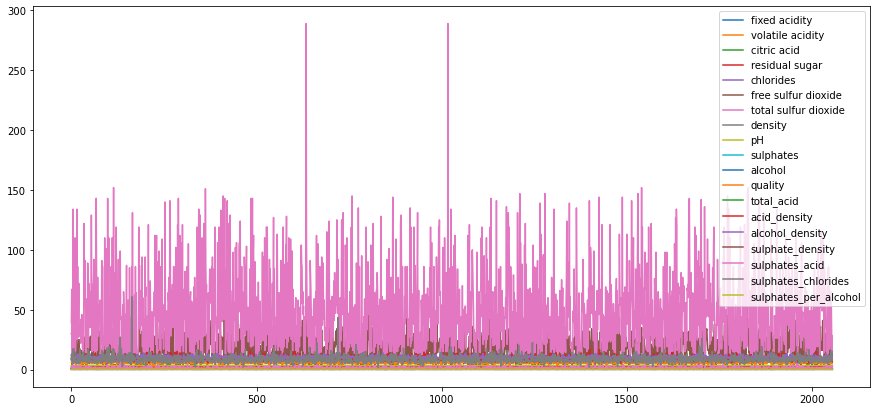

In [766]:
train_plot.plot(figsize=(15,7))

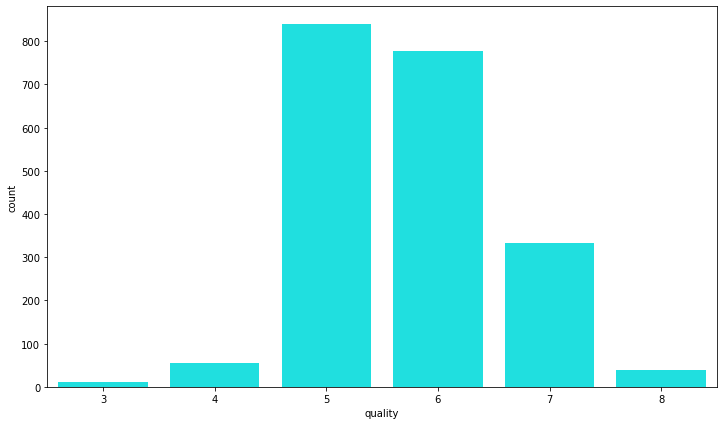

In [767]:
plt.figure(figsize=(12,7))
sns.countplot(x='quality',data=train_plot, color="cyan")
plt.show()

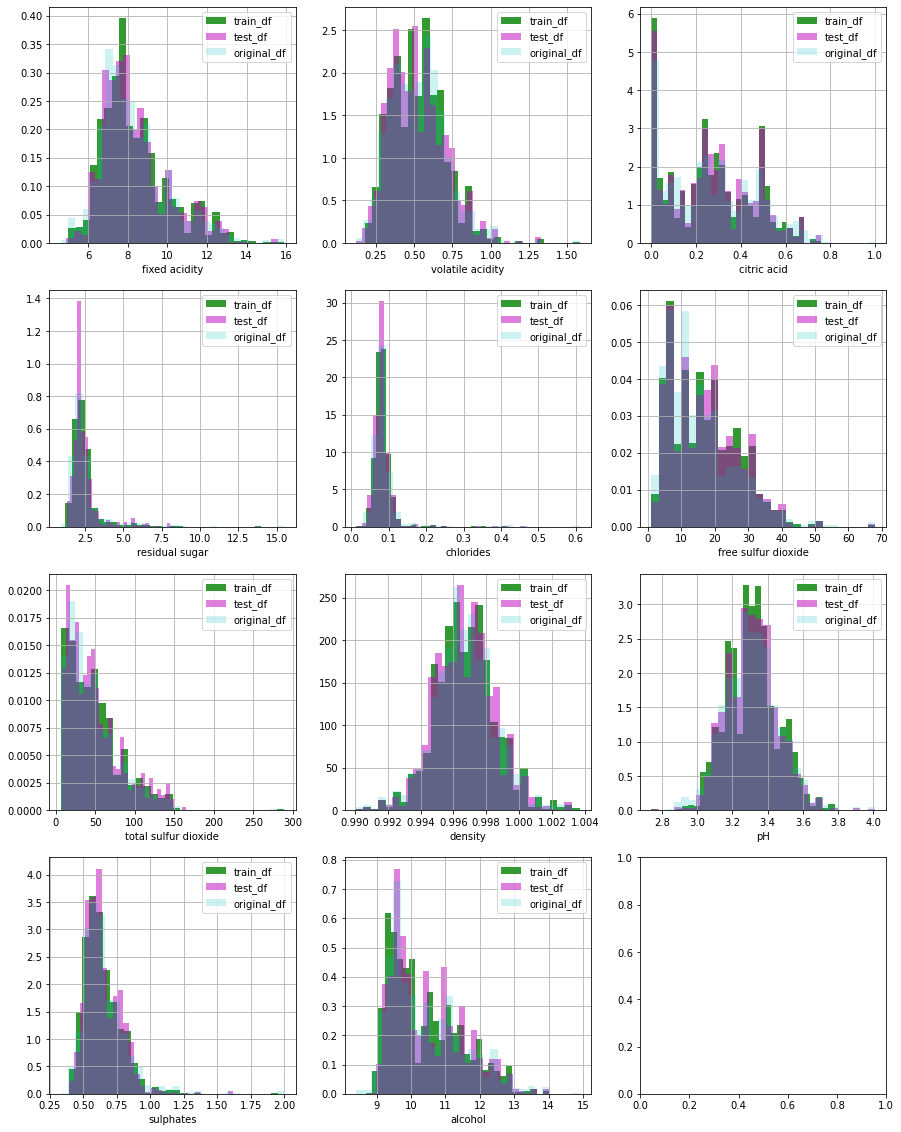

In [768]:
num_cols = 3
num_rows = math.ceil(len(FEATURE_ORIGINAL) / num_cols)
plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
for i, col in enumerate(FEATURE_ORIGINAL):
    plt.subplot(num_rows, num_cols, i+1)
    plt.hist(train_plot[col], bins=30, density=True, alpha=0.8, label="train_df", color="g")
    plt.hist(test_df[col], bins=30, density=True, alpha=0.5, label="test_df", color="m")
    plt.hist(original_df[col], bins=30, density=True, alpha=0.2, label="original_df",color="c")
    plt.xlabel(col)
    plt.legend()
    plt.grid()
plt.show()

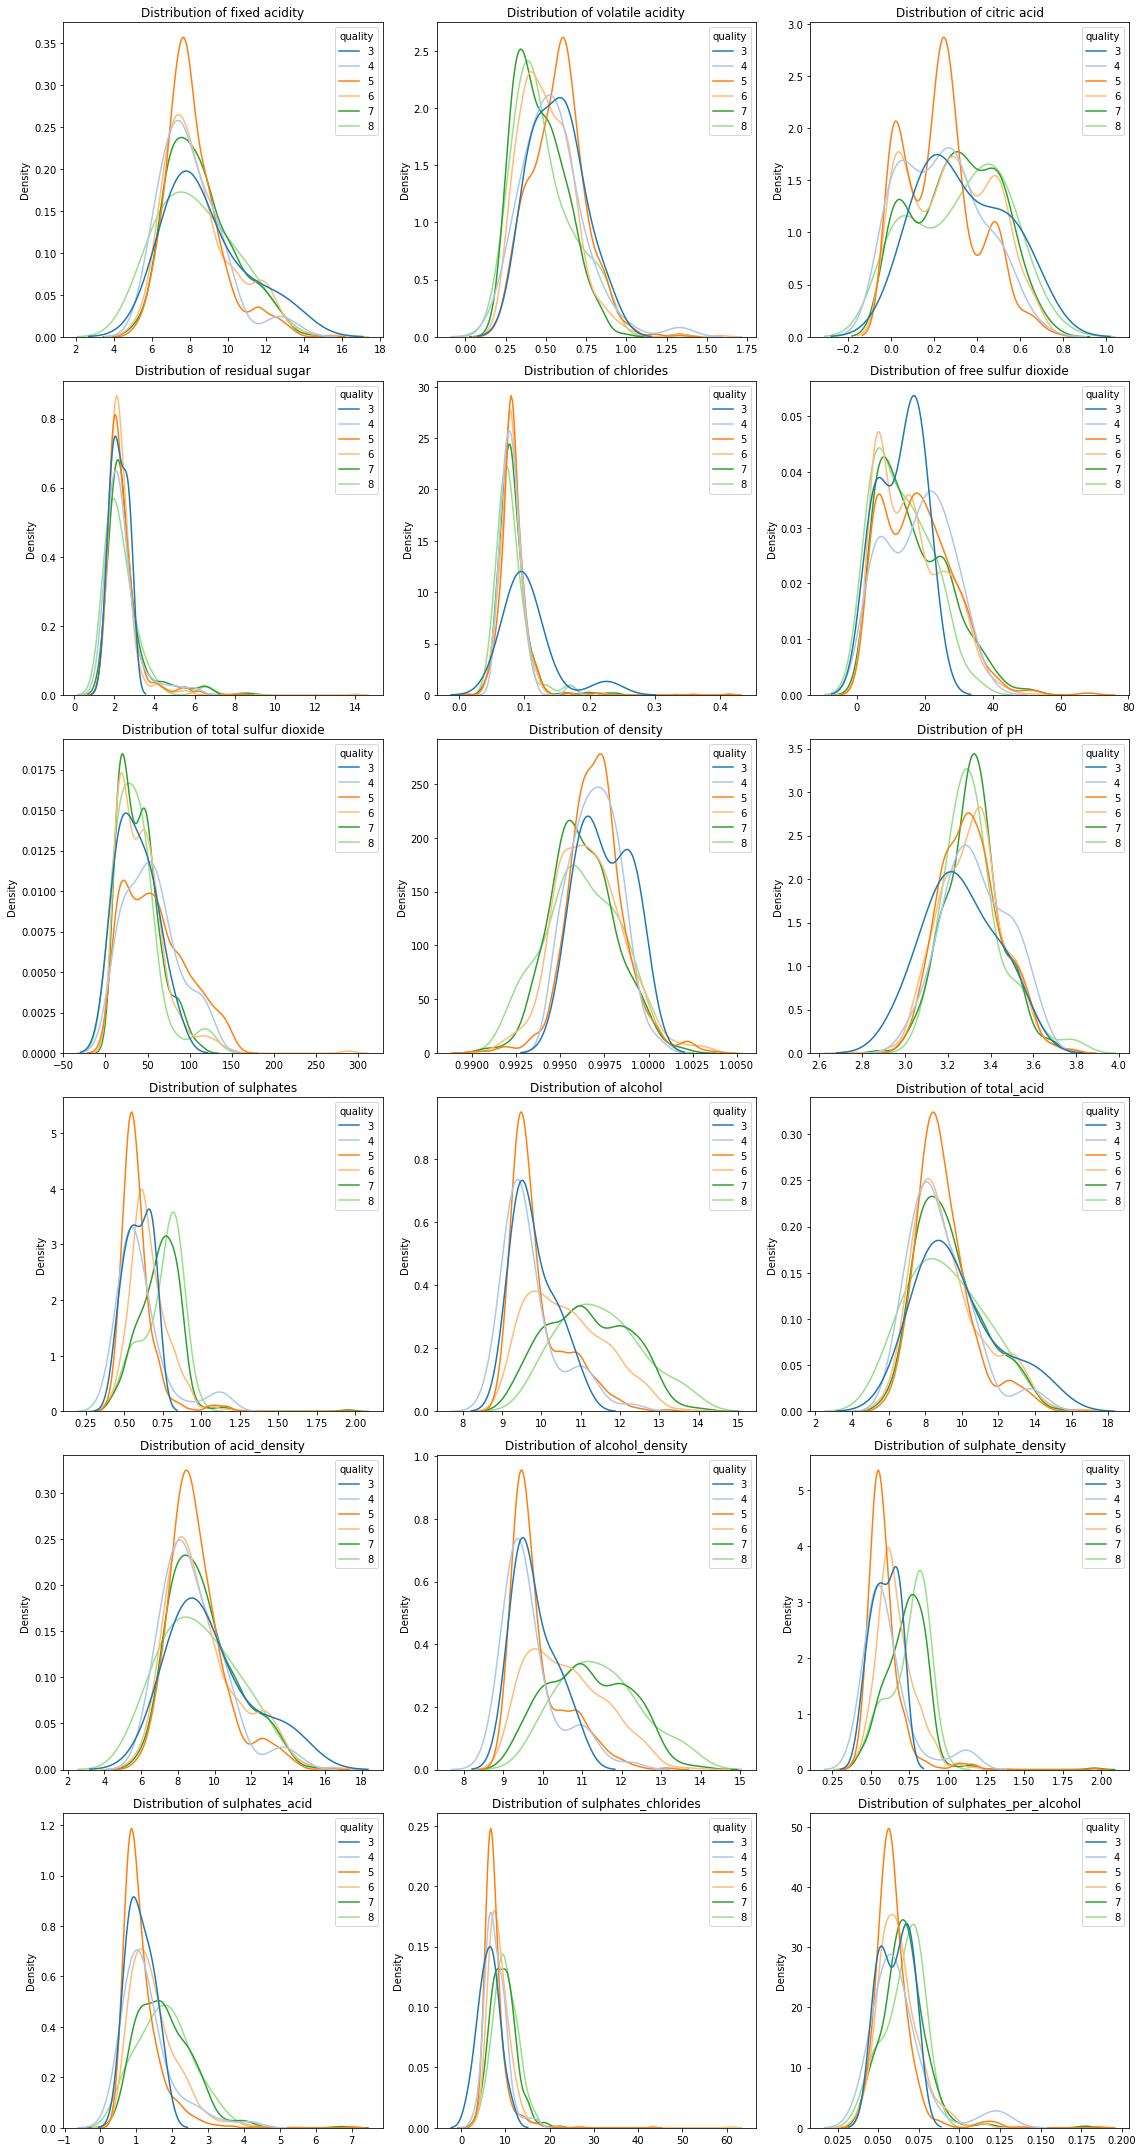

In [769]:
num_rows = math.ceil(len(FEATURE_COLS) / num_cols)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(16, num_rows*5))
ax = ax.flatten()

for x, col in enumerate(FEATURE_COLS):
    plot_axes = [ax[x]]
    
    sns.kdeplot(
        train_plot[col],
        hue=train_df.quality,
        ax=ax[x],
        common_norm=False,
        palette="tab20"
    )
    
    # titles
    ax[x].set_title(f'Distribution of {col}');
    ax[x].set_xlabel(None)
    
for i in range(x+1, len(ax)):
    ax[x].axis('off')

plt.tight_layout()

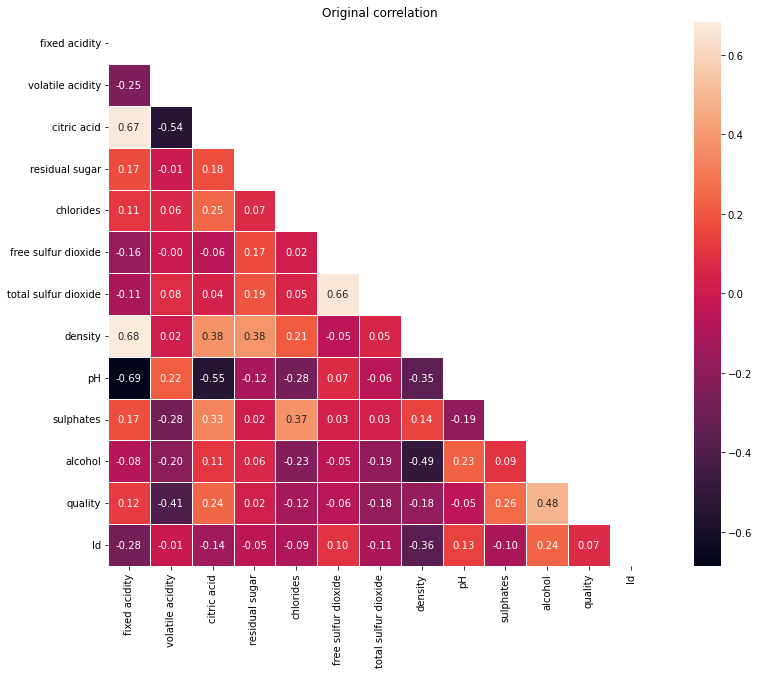

In [770]:
show_corr_heatmap(original_df, "Original correlation")

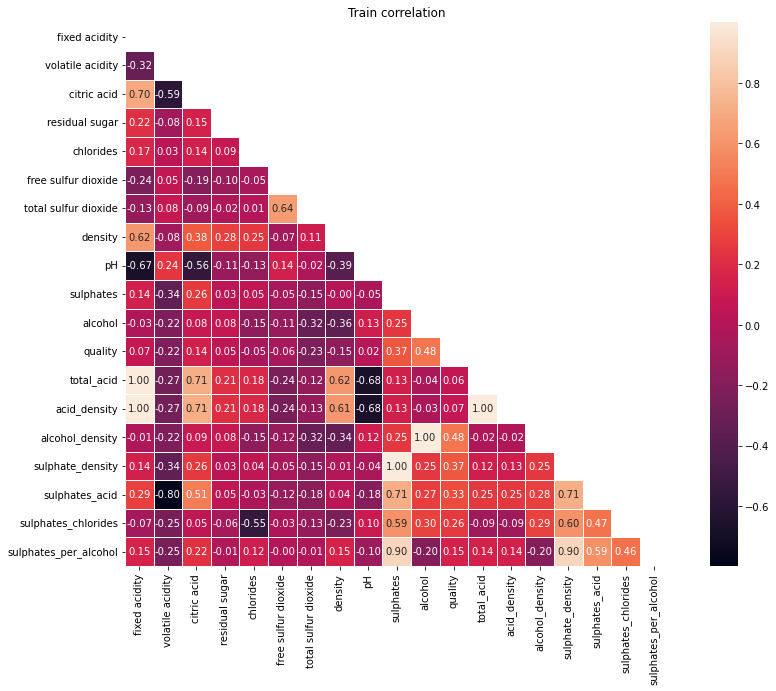

In [771]:
show_corr_heatmap(train_plot, "Train correlation")

Text(0.5, 1.0, 'quality / fixed acidity')

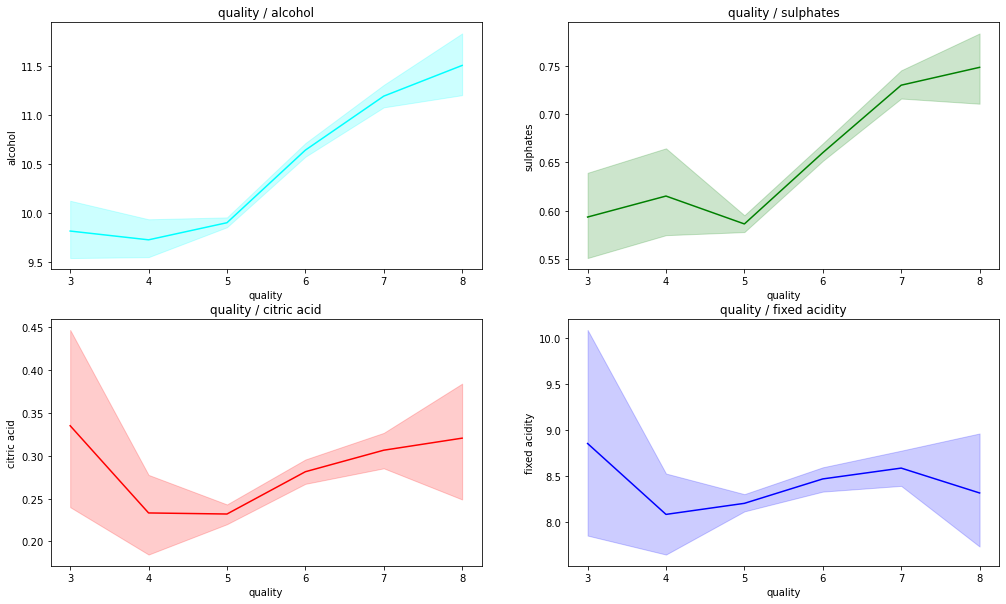

In [772]:
fig, ax = plt.subplots(2, 2, figsize=(17, 10))

sns.lineplot(ax=ax[0,0], data=train_plot, x=TARGET,y=ALCOHOL, color="cyan")
ax[0, 0].set_title(f"{TARGET} / {ALCOHOL}")
sns.lineplot(ax=ax[0,1], data=train_plot, x=TARGET,y=SULPHATES, color="green")
ax[0, 1].set_title(f"{TARGET} / {SULPHATES}")
sns.lineplot(ax=ax[1,0], data=train_plot, x=TARGET,y=CITRIC_ACID, color="red")
ax[1, 0].set_title(f"{TARGET} / {CITRIC_ACID}")
sns.lineplot(ax=ax[1,1], data=train_plot, x=TARGET,y=FIXED_ACIDITY, color="blue")
ax[1, 1].set_title(f"{TARGET} / {FIXED_ACIDITY}")

<AxesSubplot:title={'center':'fixed acidity / volatile acidity / density'}, xlabel='citric acid', ylabel='density'>

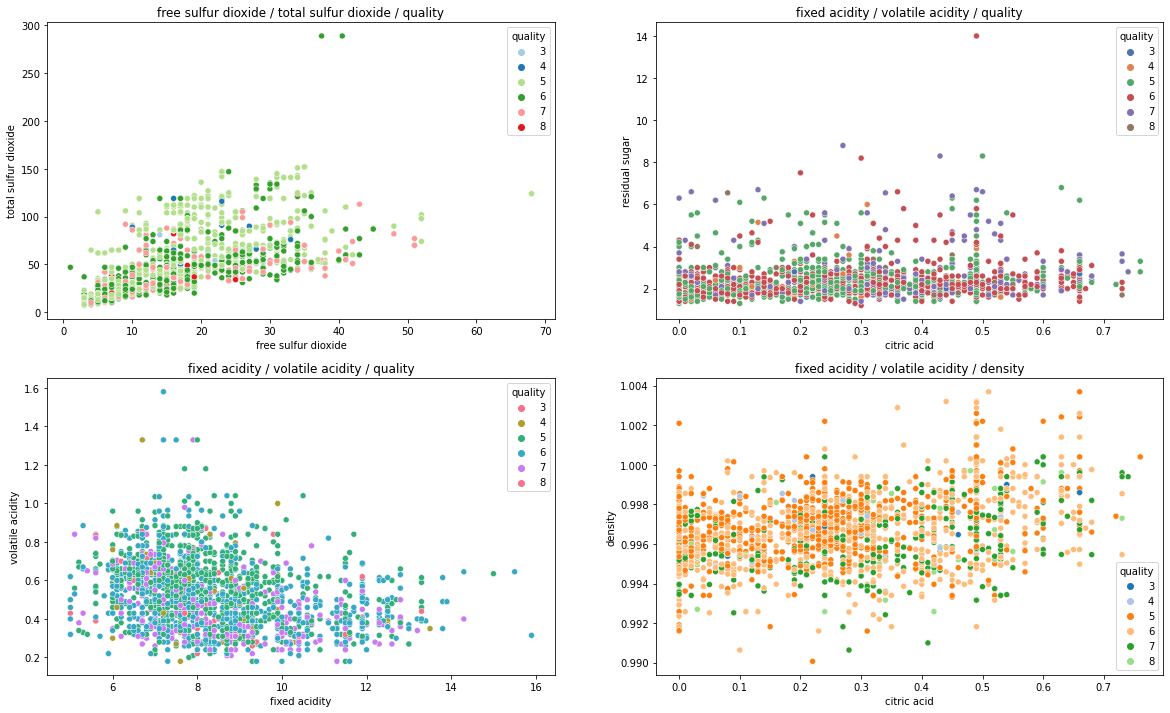

In [773]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

ax[0, 0].set_title(f"{FREE_SULFUR_DIOXIDE} / {TOTAL_SULFUR_DIOXIDE} / {TARGET}")
sns.scatterplot(x = train_plot[FREE_SULFUR_DIOXIDE],
                y=train_plot[TOTAL_SULFUR_DIOXIDE],
                ax=ax[0, 0], palette='Paired',
                hue = train_df[TARGET])

ax[1, 0].set_title(f"{FIXED_ACIDITY} / {VOLATILE_ACIDITY} / {TARGET}")
sns.scatterplot(x = train_plot[FIXED_ACIDITY],
                y=train_plot[VOLATILE_ACIDITY],
                ax=ax[1, 0],
                hue=train_df[TARGET], palette="husl")

ax[0, 1].set_title(f"{FIXED_ACIDITY} / {VOLATILE_ACIDITY} / {TARGET}")
sns.scatterplot(x = train_plot[CITRIC_ACID],
                y=train_plot[RESIDUAL_SUGAR],
                hue = train_plot[TARGET],
                ax=ax[0, 1], palette="deep")

ax[1, 1].set_title(f"{FIXED_ACIDITY} / {VOLATILE_ACIDITY} / {DENSITY}")
sns.scatterplot(x = train_plot[CITRIC_ACID],
                y=train_plot[DENSITY],
                hue = train_plot[TARGET],
                ax=ax[1, 1], palette="tab20")

In [774]:
class Config:
    path:str = PS_DIR
    gpu:bool = False
    optimize:bool = False
    n_optuna_trials:int = 5
    fast_render:bool = False
    calc_probability:bool = False
    debug:bool = False
    seed:int = 42
    N_ESTIMATORS:int = 1000  
    GPU_N_ESTIMATORS:int = 1000 
    N_FOLDS:int = 5

In [775]:
lgbm_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    "n_estimators" : Config.N_ESTIMATORS,
    "learning_rate": 0.05
    
}

# https://www.kaggle.com/code/usedpython/s3e5-0-599-xgb-lgb-lg

lgb_params_best_bsmith = {
    "boosting_type": "goss",
    "num_leaves": 38,
    "learning_rate": 0.2845475116961482,
    "n_estimators": 290,
    "max_depth": 4,
    "min_child_samples": 72,
    "subsample": 0.8166188575050211,
    "colsample_bytree": 0.27881478520246883,
    "reg_alpha": 0.411886427222449,
    "reg_lambda": 0.9994503751899053
    }

xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',

}

xgb_params = {'max_depth': 1,
             'learning_rate': 0.38948972099234563,
             'gamma': 0.5992826807539955,
             'subsample': 0.760188310145391,
             'colsample_bytree': 0.9470322372755515,
             'reg_alpha': 0.8286639480742322,
             'reg_lambda': 0.6987138355697013,
             'objective' : " multi:softmax",
             'n_estimators': Config.N_ESTIMATORS,
             'num_class': 6,
             }
cb_params = {
    "objective": "MultiClass",
    "loss_function" : "WKappa",
    "random_seed": Config.seed,
}

cb_params2 = {
    'iterations': Config.seed,
    'learning_rate': 0.01,
    'depth': 1,
    'eval_metric': 'AUC',
    'verbose': 100,
    'od_type': 'Iter',
    'od_wait': 500,
    'random_seed': 1,
    'task_type': 'CPU'
}


In [776]:
model_estimator_dict = {
    "xgb1": xgb.XGBClassifier(**xgb_params),
    "lgbm1": lgbm.LGBMClassifier(**lgbm_params),
    "lgbm2": lgbm.LGBMClassifier(**lgb_params_best_bsmith),    
    
    "cat1": cb.CatBoostClassifier(**cb_params),
    "cat2": cb.CatBoostClassifier(**cb_params2),
}

In [777]:
model_list = ["lgbm1", "lgbm2", "cat1", "cat2"]

In [778]:
train = create_strat_folds(train_df, TARGET, Config.N_FOLDS)

TARGET=quality, n_folds=5, seed=42


In [779]:
all_cv_scores = pd.DataFrame(
    {
        "Model": pd.Series(dtype="str"),
        "Score": pd.Series(dtype="float"),
        "StdDev": pd.Series(dtype="float"),
        "RunTime": pd.Series(dtype="float"),
    }
)


Model=lgbm1
{}
========== Fold 1/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 1, Score: 0.42799322289156616, Run Time: 6.27
========== Fold 2/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 2, Score: 0.4726005424480154, Run Time: 7.67
========== Fold 3/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 3, Score: 0.41490928369462776, Run Time: 6.56
========== Fold 4/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 4, Score: 0.43519161294892683, Run Time: 6.83
========== Fold 5/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 5, Score: 0.44632798155241593, Run Time: 6.58
Scores -> Adjusted: 0.41992175 , mean: 0.43940453, std: 0.01948278


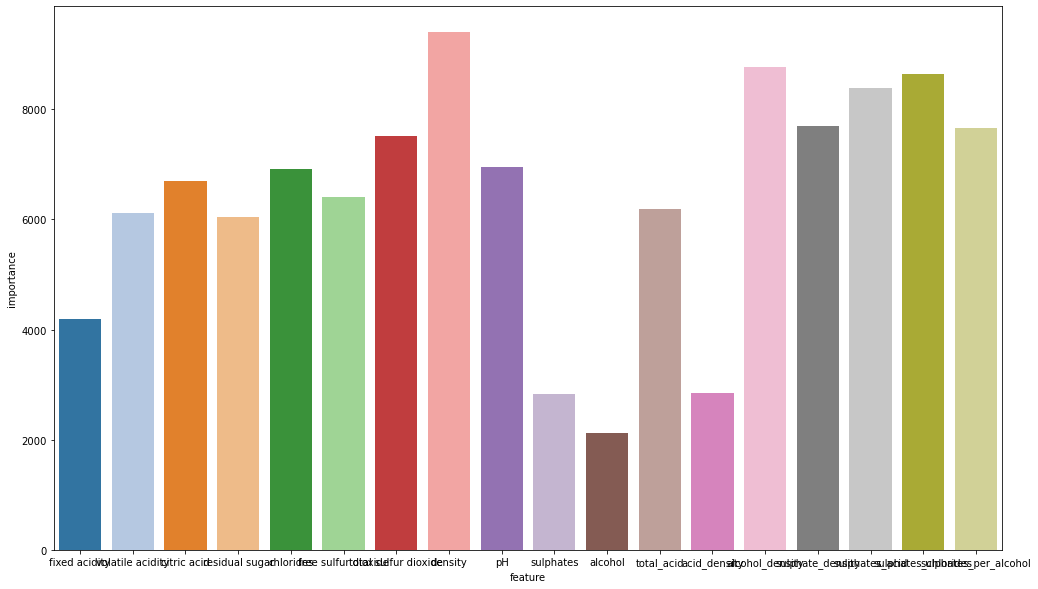

,pred_lgbm1
Id,
0,6
1,6
2,7
3,5
4,5


Mode
=== Target Value Counts ===


6    610
5    594
7    167
4      1
Name: quality, dtype: int64

Model Run Time: 34.35
Model=lgbm2
{}
========== Fold 1/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 1, Score: 0.401884937199681, Run Time: 0.52
========== Fold 2/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 2, Score: 0.43662216559033906, Run Time: 0.55
========== Fold 3/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 3, Score: 0.3998494987771777, Run Time: 0.57
========== Fold 4/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 4, Score: 0.42810673698521395, Run Time: 0.52
========== Fold 5/5 ==========


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 5, Score: 0.36818872022452365, Run Time: 0.54
Scores -> Adjusted: 0.38282003 , mean: 0.40693041, std: 0.02411038


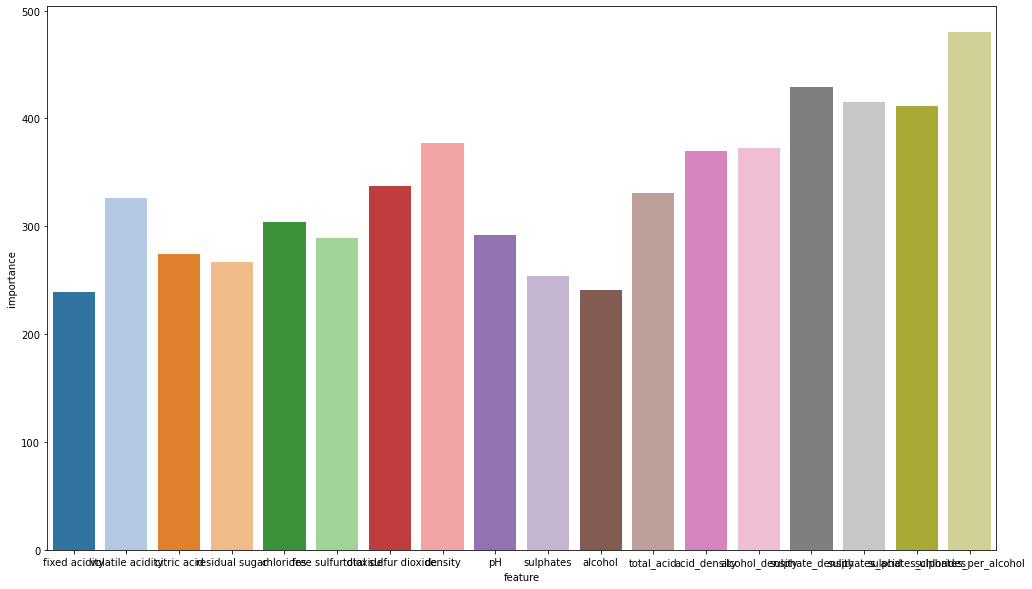

,pred_lgbm2
Id,
0,6
1,6
2,6
3,5
4,6


Mode
=== Target Value Counts ===


6    601
5    587
7    178
4      4
8      2
Name: quality, dtype: int64

Model Run Time: 3.05
Model=cat1
{}
========== Fold 1/5 ==========
fold: 1, Score: 0.4730307284355014, Run Time: 9.92
========== Fold 2/5 ==========
fold: 2, Score: 0.5167989297333455, Run Time: 9.55
========== Fold 3/5 ==========
fold: 3, Score: 0.4495895066139456, Run Time: 9.51
========== Fold 4/5 ==========
fold: 4, Score: 0.4881121227371856, Run Time: 9.95
========== Fold 5/5 ==========
fold: 5, Score: 0.5112457593525902, Run Time: 9.65
Scores -> Adjusted: 0.46298082 , mean: 0.48775541, std: 0.02477459


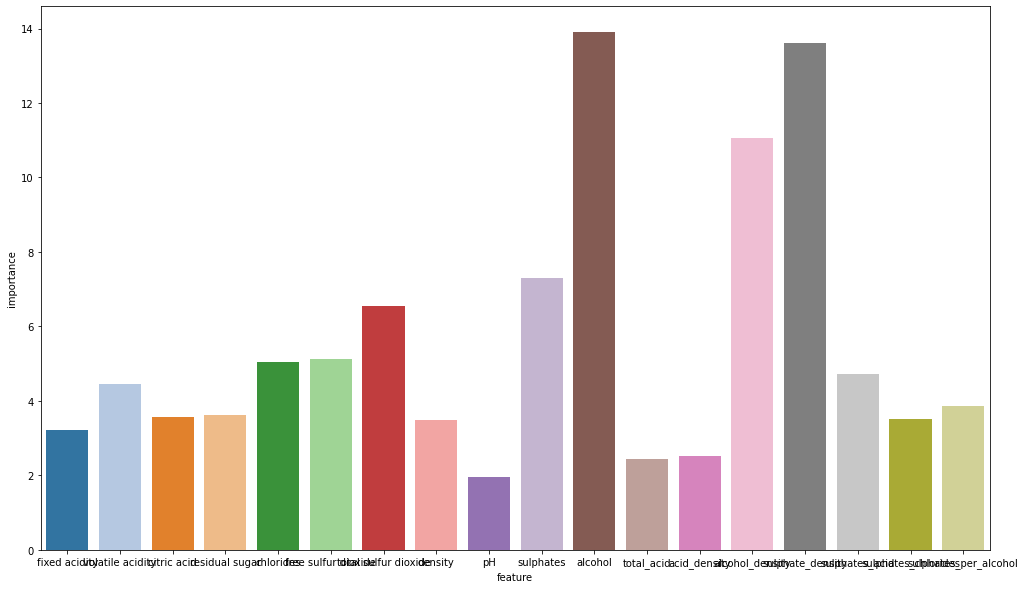

,pred_cat1
Id,
0,7
1,6
2,6
3,5
4,5


Mode
=== Target Value Counts ===


6    656
5    575
7    141
Name: quality, dtype: int64

Model Run Time: 49.01
Model=cat2
{}
========== Fold 1/5 ==========
fold: 1, Score: 0.3627384809215263, Run Time: 0.13
========== Fold 2/5 ==========
fold: 2, Score: 0.41637516018425513, Run Time: 0.12
========== Fold 3/5 ==========
fold: 3, Score: 0.3227610593923649, Run Time: 0.14
========== Fold 4/5 ==========
fold: 4, Score: 0.36781212033393895, Run Time: 0.12
========== Fold 5/5 ==========
fold: 5, Score: 0.4363955069041997, Run Time: 0.13
Scores -> Adjusted: 0.34067264 , mean: 0.38121647, std: 0.04054382


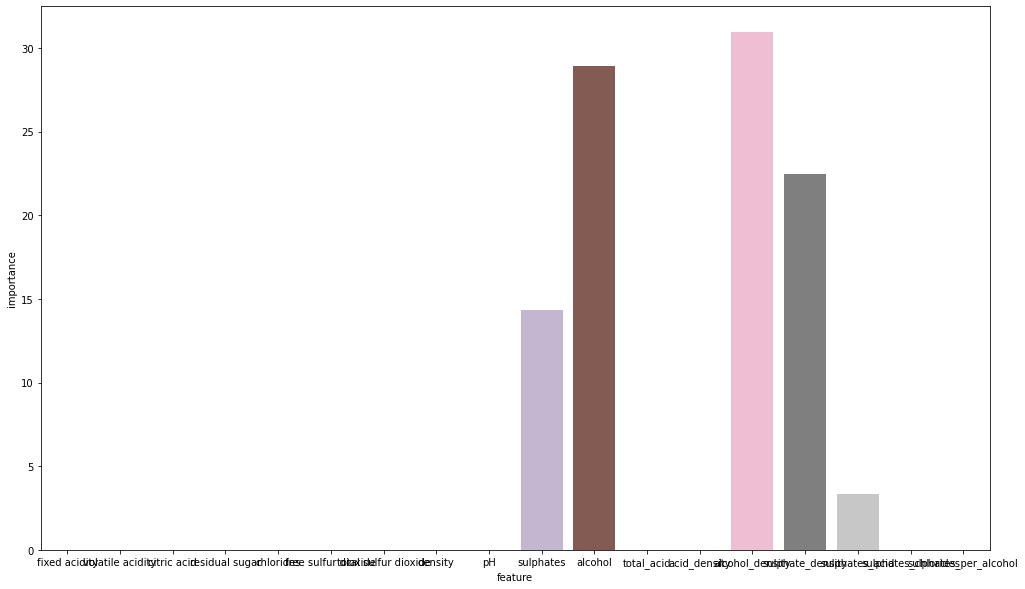

,pred_cat2
Id,
0,6
1,6
2,6
3,5
4,5


Mode
=== Target Value Counts ===


6    770
5    602
Name: quality, dtype: int64

Model Run Time: 1.06


In [780]:
all_cv_scores = model_feat(model_estimator_dict, model_list,
                           TARGET, FEATURE_ORIGINAL, all_cv_scores,
                           linear_models=False)

In [787]:
all_cv_scores.head(10)

,Model,Score,StdDev,RunTime
0,lgbm1,0.439405,0.019483,34.346536
1,lgbm2,0.406930,0.024110,3.051333
2,cat1,0.487755,0.024775,49.008867
3,cat2,0.381216,0.040544,1.056114


In [781]:
sample_df.head(20)

,Id,quality,target_lgbm1,target_lgbm2,target_cat1,target_cat2
0,2056,5,6,5,5,5
1,2057,5,6,7,6,6
2,2058,5,6,6,5,5
3,2059,5,6,6,6,6
4,2060,5,5,5,6,6
5,2061,5,6,5,6,6
6,2062,5,6,6,6,6
7,2063,5,6,6,6,6
8,2064,5,6,5,6,6
9,2065,5,5,5,6,6


In [782]:
mode_result = mode([1,1,3,3,3,4])
result = mode_result[0].ravel()
result

array([3])

In [783]:
sample_df[TARGET] = (
    + (sample_df["target_lgbm1"])
    + (sample_df["target_lgbm2"])    
    + (sample_df["target_cat1"] )
    + (sample_df["target_cat2"] )    
)/4

sample_df[TARGET] = sample_df[TARGET].astype(int)

In [784]:
sample_df[["Id", TARGET]].to_csv("submission.csv", index=False)
sample_df[["Id", TARGET]].tail(8)

,Id,quality
1364,3420,5
1365,3421,6
1366,3422,6
1367,3423,5
1368,3424,6
1369,3425,5
1370,3426,5
1371,3427,5


In [785]:
sample_df[TARGET].value_counts()

5    773
6    596
4      3
Name: quality, dtype: int64